# Pre-process Dataset

We are going to load the dataset https://snap.stanford.edu/data/wiki-Vote.html 
and transform it by adding labels to some edeges that represent emulated topics.

The topological graph structure was kept from the original graph.


In [14]:
import os
import random
from zipfile import ZipFile
from StringIO import StringIO

dataset_path = os.path.join('..', 'datasets', 'wiki.txt.zip')
wiki_file = StringIO(ZipFile(dataset_path).read('wiki-Vote.txt'))

## Helper functions

In [15]:
def id_generator(seed=0):
    "Generator to produce sequential IDs"
    while True:
        yield seed
        seed += 1
        
def convert_line(line):
    "Ignore comments (#) and strip values from columns"
    if not line.strip() or line.startswith('#'):
        return None, None
    from_node, to_node = line.split()
    return from_node.strip(), to_node.strip()


## Templates for generating GraphML output

In [16]:
template_structure ="""<?xml version="1.0" encoding="UTF-8"?>
<graphml xmlns="http://graphml.graphdrawing.org/xmlns">  
<key attr.name="topic" attr.type="string" for="edge" id="topic" />
<graph edgedefault="directed">
{NODES}
{EDGES}
</graph>
</graphml>
"""

template_node = '<node id="{node_id}"/>'

template_edge = '<edge id="{edge_id}" directed="true" source="{from_node}" target="{to_node}"> <data key="topic">{topic}</data> </edge>'


## Define some topics

In [17]:
topics = ['Athletics', 'Cultural Center', 'Dorms', 'Food', 'Groceries']

# Convert input dataset into GraphML file

In [18]:
output_file = os.path.join('..', 'datasets', 'wiki.graphml')

nodes = set()
edges = []
edge_id_gen = id_generator()

for line in wiki_file.readlines():
    from_node, to_node = convert_line(line)
    if from_node is None:
        continue
    nodes.add(from_node)
    nodes.add(to_node)
    edges.append((from_node, to_node))

node_lines = '\n'.join(template_node.format(node_id=id) for id in nodes)
edge_lines = '\n'.join(template_edge.format(from_node=f, 
                                            to_node=t, 
                                            edge_id=edge_id_gen.next(),
                                            topic=random.choice(topics)) for f, t in edges)
with open(output_file, 'wb') as out_fd:
    out_fd.write(template_structure.format(NODES=node_lines, EDGES=edge_lines))


## Test the generated graphml file using networkx

In [27]:
import networkx as nx
G = nx.read_graphml(output_file)
print("{0} nodes {1} edges".format(len(G.nodes()), len(G.edges())))

7115 nodes 103689 edges


## Generate smaller graph 

In [51]:
subnodes = G.nodes()[:300]
sG = G.subgraph(subnodes)
nx.write_graphml(sG, os.path.join('..', 'datasets', 'small_wiki.graphml'))
print("{0} nodes {1} edges".format(len(sG.nodes()), len(sG.edges())))

300 nodes 245 edges


## Graph Visualization

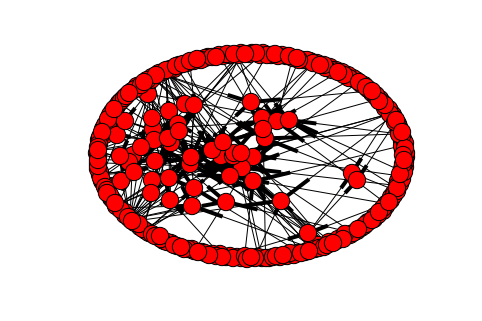

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(sG)
plt.show()

## Produced with Gephi
![produced with Gephi](tiny_wiki.png)
![produced with Gephi](small-wiki.png)


## Graph Analysis

Some metrics can only be computed by networkx by using undirected graphs.

In [89]:
usG = sG.to_undirected()

In [90]:
cc = nx.connected_components(usG)
cc_sizes = list(reversed(sorted([len(i) for i in cc])))

try:
    idx = cc_sizes.index(1)
    isolated = len(cc_sizes[idx:])
except ValueError:
    isolated = 0
print("{0} connected components and {1} isolated nodes".format(cc_sizes[:idx], isolated))

[128, 5, 2, 2, 2, 2] connected components and 159 isolated nodes


In [92]:
cluster_dict = nx.clustering(usG)

# Computing Committee

Selecting a committee based on the delegation graph
To select N people on a topic T from a set where K people have expressed their expertise on T, where K > N, the following simple algorithm can be used: 

1. Compute the sum of delegation power for each person on T
2. If there is single person with the most delegative power, add them to the committee.
3. Else if there are a number of people who are equal, compute their independent delegative power, and if there is a single person with the most delegative power, add them to the committee. 
4. Else if there are still people with equal delegative power, pick one randomly to add to the committee.
5. For the candidate added to the committee, remove all their delegations on topic T.
6. All candidates who delegated to T will be considered represented, and are removed from the graph for further computation of member of the committee.

When the results are published, the committee members are shown with the count of number of people delegated to them. This allows committees to give delegates proportionate voting rights based on their number of delegates.

There are many other algorithms to compute committees where the delegation count is not relevant. But these are not explored here as we have the delegation counts.

## Create subgraph of a given specific topic

In [65]:
topic_E = []
filter_topic = topics[-1] # Groceries 
for e in sG.edges_iter():
    edge_attrs = sG.get_edge_data(*e)
    if edge_attrs['topic']==filter_topic:
        topic_E.append(e)

topic_G = nx.DiGraph(E)
print("{0} nodes {1} edges".format(len(topic_G.nodes()), len(topic_G.edges())))

65 nodes 49 edges


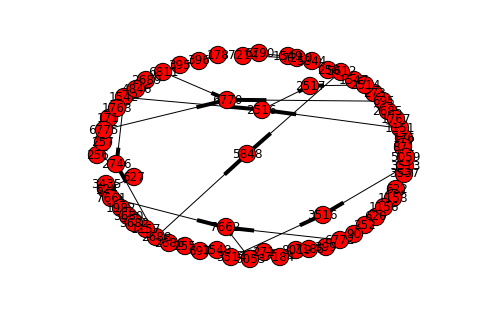

In [66]:
nx.draw(topic_G, with_labels=True)
plt.show()

In [67]:
def compute_powers(G): 
    "Computes a descending sorted list of (power, node_id) tuples"
    V = G.nodes()
    powers = dict(zip(V, [0]*len(V)))
    for dst in V:
        for src in V:
            if nx.has_path(G, src, dst):
               powers[dst] += 1 
    return reversed(sorted((v,k) for k,v in powers.items()))


In [68]:
top_powers = compute_powers(topic_G)

In [69]:
top_k = 10
top_k_powers = []
for i in range(1, top_k):
    top_k_powers.append(top_powers.next())
print(top_k_powers)

[(7, '5844'), (6, '2517'), (6, '1549'), (6, '1547'), (4, '7662'), (4, '6770'), (4, '3537'), (4, '271'), (4, '2516')]
